# URL dataset (ISCX-URL2016)

## Description

The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We explore a lightweight approach to detection and categorization of the malicious URLs according to their attack type and show that lexical analysis is effective and efficient for proactive detection of these URLs. We also study the effect of the obfuscation techniques on malicious URLs to figure out the type of obfuscation technique targeted at specific type of malicious URL. We study mainly five different types of URLs:

Benign URLs: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

Spam URLs: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

Phishing URLs: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

Malware URLs: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

Defacement URLs: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

Obfuscation is used as a common method for masking malicious URLs. An attacker intending to evade static analysis on lexical URL features use obfuscation techniques so that malicious URLs become statistically like the benign ones. The obfuscation techniques on URLs is analyzed for the intent of malicious activity in this research. We analyzed mainly Spam, Phishing and Malware URLs to see what kind of obfuscation techniques applied on the URLs.

The full research paper outlining the details of the dataset and its underlying principles:

    Mohammad Saiful Islam Mamun, Mohammad Ahmad Rathore, Arash Habibi Lashkari, Natalia Stakhanova and Ali A. Ghorbani, "Detecting Malicious URLs Using Lexical Analysis", Network and System Security, Springer International Publishing, pp. 467-482, 2016.


[Download this dataset](https://www.unb.ca/cic/datasets/url-2016.html#:~:text=Download%20this%20dataset)


# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline 

## Funciones auxiliares

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Representacion grafica del limite del limite de decision
def plot_svm_decision_boundary(svm_clf,xmin,xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0 * x0 + w1 * x1 + b = 0
    # => x1 = -(w0 * x0 - b) / w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -(w[0] * x0 + b) / w[1]

    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    # Especificar el size de los marcadores
    plt.scatter(svs[:, 0], s=180, facecolors='#FFAAAA')

    plt.plot(x0, decision_boundary, "k-",linewidth=2)
    plt.plot(x0, gutter_up, "k--",linewidth=2) 
    plt.plot(x0, gutter_down, "k--",linewidth=2)
    

## 1.- Lectura del Dataset

In [5]:
df=pd.read_csv("./datasets/FinalDataset/Phishing.csv")

## 2.- Visualizacion preliminar de la informacion

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [7]:
df.describe()

/home/maury/Sources/Simulacion/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [9]:
df["URL_Type_obf_Type"].value_counts()

URL_Type_obf_Type
benign      7781
phishing    7586
Name: count, dtype: int64

In [10]:
# Comprobar la existencia de valores nulos
is_null = df.isnull().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
Entropy_Afterpath           True
dtype: bool

In [11]:
# Comprobar la existencia de valores infinitos
is_infi=df.isin([np.inf, -np.inf]).any()
is_infi[is_infi]

argPathRatio    True
dtype: bool

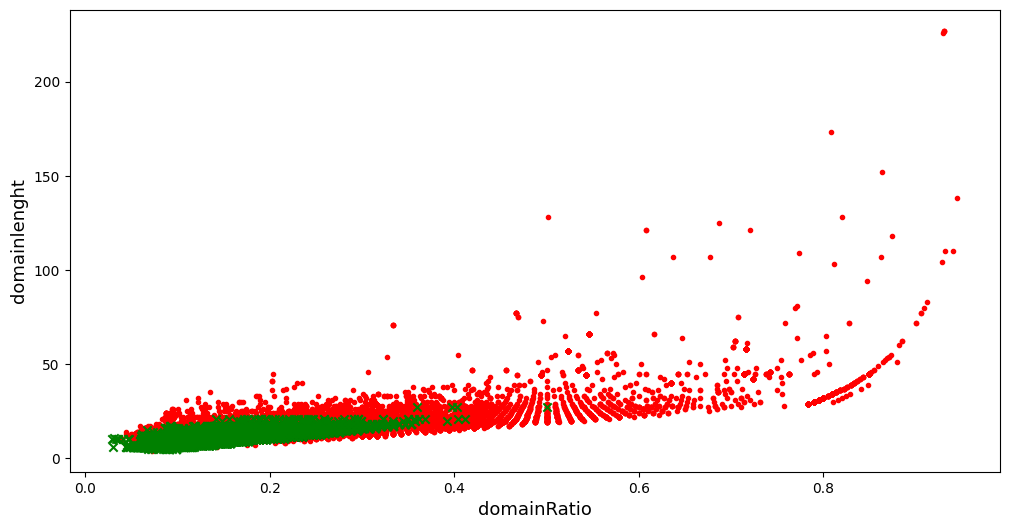

In [12]:
# Representacion grafica de dos caracteristicas
plt.figure(figsize=(12,6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type']=="phishing"],df['domainlength'][df['URL_Type_obf_Type']=='phishing'],c='r',marker='.')
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type']=="benign"],df['domainlength'][df['URL_Type_obf_Type']=='benign'],c='g',marker='x')
plt.xlabel("domainRatio",fontsize=13)
plt.ylabel("domainlenght",fontsize=13)
plt.show()

## 3.- Division del DataSet

In [13]:
train_set,val_set,test_set=train_val_test_split(df)

In [14]:
x_train = train_set.drop("URL_Type_obf_Type", axis=1)
y_train = train_set["URL_Type_obf_Type"].copy()

x_val = val_set.drop("URL_Type_obf_Type", axis=1)
y_val = val_set["URL_Type_obf_Type"].copy()

x_test = test_set.drop("URL_Type_obf_Type", axis=1)
y_test = test_set["URL_Type_obf_Type"].copy()


## 4.-Preparar el DataSet 

In [15]:
#Eliminar el atributo que tiene valores infinitos
x_train=x_train.drop("argPathRatio", axis=1)
x_val=x_val.drop("argPathRatio", axis=1)
x_test=x_test.drop("argPathRatio", axis=1)

In [16]:
# Rellenar valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer=SimpleImputer(strategy="median")


In [17]:
#Rellenar los valores nulos 
x_train_prep=imputer.fit_transform(x_train)
x_val_prep=imputer.transform(x_val)
x_test_prep=imputer.transform(x_test)

In [18]:
#Transformar el resultado a un DataFrame de Pandas

X_train_prep = pd.DataFrame(x_train_prep, columns=x_train.columns,index=y_train.index)
X_val_prep = pd.DataFrame(x_val_prep, columns=x_val.columns,index=y_val.index)
X_test_prep = pd.DataFrame(x_test_prep, columns=x_test.columns,index=y_test.index)

X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
2134,0.0,2.0,6.0,2.000000,2.0,8.666667,2.0,17.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.681183,0.827729,0.702637,0.849605,0.000000,-1.000000
9178,0.0,4.0,18.0,3.250000,5.0,1.000000,4.0,18.0,13.0,2.0,...,12.0,3.0,0.0,4.0,0.695232,0.820160,0.682849,0.875578,0.000000,0.778747
13622,0.0,3.0,3.0,6.666666,14.0,4.000000,3.0,1.0,1.0,1.0,...,1.0,0.0,0.0,-1.0,0.836006,0.869991,0.879588,1.000000,0.000000,-1.000000
15182,0.0,3.0,5.0,3.333333,4.0,3.000000,3.0,5.0,2.0,0.0,...,2.0,1.0,0.0,-1.0,0.731804,0.796490,0.796658,1.000000,1.000000,-1.000000
8013,74.0,2.0,13.0,9.500000,17.0,7.875000,2.0,21.0,29.0,26.0,...,4.0,5.0,4.0,3.0,0.653371,0.820569,0.758055,0.714969,0.712215,0.708031
12408,0.0,3.0,4.0,8.333333,19.0,3.750000,3.0,5.0,1.0,0.0,...,2.0,0.0,0.0,-1.0,0.726479,0.789538,0.800705,1.000000,0.000000,-1.000000
509,20.0,2.0,13.0,4.500000,6.0,3.000000,2.0,24.0,17.0,0.0,...,1.0,14.0,13.0,12.0,0.678515,0.796658,0.871049,0.695112,0.701662,0.698106
10714,0.0,3.0,8.0,6.666666,14.0,4.250000,3.0,11.0,5.0,0.0,...,4.0,0.0,0.0,-1.0,0.745348,0.869991,0.788921,1.000000,0.000000,-1.000000
3986,0.0,2.0,6.0,6.500000,10.0,4.500000,2.0,7.0,7.0,0.0,...,2.0,0.0,0.0,-1.0,0.760843,0.798231,0.822491,0.796670,0.000000,-1.000000
748,0.0,2.0,8.0,4.000000,5.0,5.750000,2.0,14.0,14.0,1.0,...,2.0,0.0,0.0,-1.0,0.709062,0.929897,0.884735,0.674994,0.000000,-1.000000


In [19]:
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

## 5.- SMV:Kernel Lineal

### 5.1-DataSet reducido 

#### Entrenamiento del Algoritmo con un DataSet Reducido

In [20]:
# Reducir el DataSet para reemplazarlo graficamente

x_train_reduce = X_train_prep[['domainUrlRatio',"domainlength"]].copy()
x_val_reduce = X_val_prep[['domainUrlRatio',"domainlength"]].copy()

x_train_reduce

,domainUrlRatio,domainlength
2134,0.072464,5.0
9178,0.166667,16.0
13622,0.511628,22.0
15182,0.315789,12.0
8013,0.107527,20.0
...,...,...
5191,0.116667,14.0
13418,0.477273,21.0
5390,0.157895,9.0
860,0.072917,7.0


In [21]:
from sklearn.svm import SVC

# SVC Large margin classification
# C = regularization parameter
# Podemos caer en overfitting
svm_clf=SVC(kernel="linear",C=50)
svm_clf.fit(x_train_reduce, y_train)

,C,50
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [22]:
# Representacion grafica del limite del limite de decision
def plot_svm_decision_boundary(svm_clf,xmin,xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0 * x0 + w1 * x1 + b = 0
    # => x1 = -(w0 * x0 - b) / w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -(w[0] * x0 + b) / w[1]

    margin = 1 / w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    # Especificar el size de los marcadores
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')

    plt.plot(x0, decision_boundary, "k-",linewidth=2)
    plt.plot(x0, gutter_up, "k--",linewidth=2) 
    plt.plot(x0, gutter_down, "k--",linewidth=2)

Text(0, 0.5, 'domainlength')

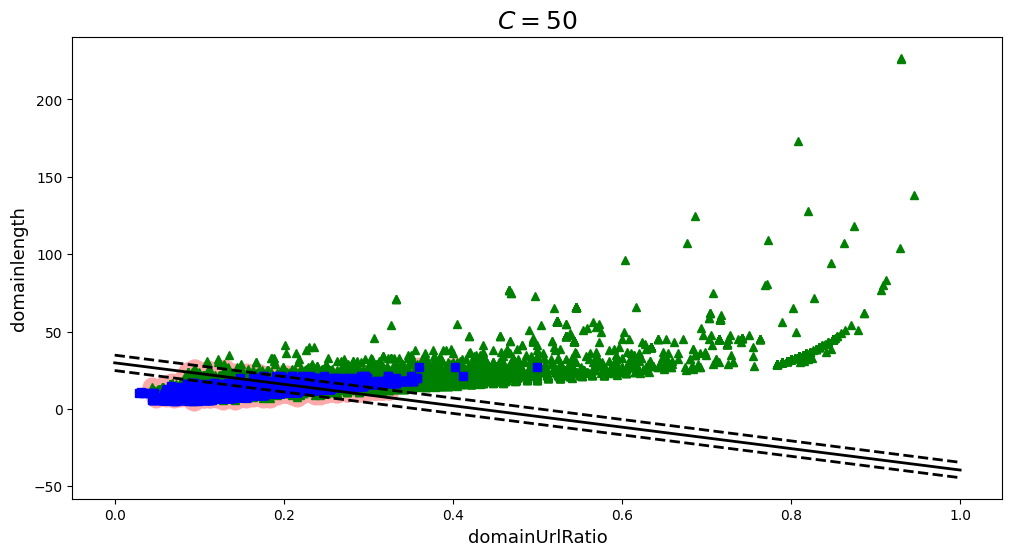

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(x_train_reduce.values[:,0][y_train == "phishing"],x_train_reduce.values[:,1][y_train == "phishing"], "g^")
plt.plot(x_train_reduce.values[:,0][y_train == "benign"],x_train_reduce.values[:,1][y_train == "benign"], "bs")
plot_svm_decision_boundary(svm_clf, 0,1)
plt.title("$C = {}$".format(svm_clf.C),fontsize=18)
plt.xlabel("domainUrlRatio",fontsize=13)
plt.ylabel("domainlength",fontsize=13)

Prediccion con un DataSet reducido

In [24]:
y_pred = svm_clf.predict(x_val_reduce)
print("F1 Score:", f1_score(y_pred,y_val,pos_label="phishing"))

F1 Score: 0.8142614601018676


Como se vera mas adelante para determinados kernels es muy importante escalar el DataSet, en ese caso para el kernel lineal no estan relevante aunque es posible que proporciones mejores resutados.

In [25]:
svm_clf_sc = Pipeline([
    ("scaler", RobustScaler()),
    ("linear_svc", SVC(kernel="linear", C=50))
])

svm_clf_sc.fit(x_train_reduce, y_train)

,steps,"[('scaler', ...), ('linear_svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,C,50
,kernel,'linear'


In [26]:
y_pred=svm_clf_sc.predict(x_val_reduce)
print("F1 Score:", f1_score(y_pred,y_val,pos_label="phishing"))

F1 Score: 0.8141592920353983


### 5.2- DataSet completo

In [35]:
# Entrenamiento con todo el DataSet
svm_clf=SVC(kernel="linear",C=10)
svm_clf.fit(x_train_prep, y_train)

,C,10
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [36]:
y_pred=svm_clf.predict(x_val_prep)
print("F1 Score:", f1_score(y_pred,y_val,pos_label="phishing"))

F1 Score: 0.9620336744800264
